# Atmospheric composition distribution by CAMS and IASI

### Main goal:
* Compare IASI and CAMS datasets for CO and O<sub>3</sub>.

## Imports and supporting functions

In [4]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
import datetime # Important for IASI

In [5]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [6]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [7]:
component_nom = 'O3'
sensor = 'iasi'
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [8]:
# Define latitudes and longitudes
lat_min = 30
lat_max = 70
lon_min = -25
lon_max = 45

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
print('SEARCH PERIOD')

# IASI
dates_unsorted = ('2020-01', '2020-02', '2021-07', '2020-04')
dates = tuple(sorted(dates_unsorted))
start_date = dates[0]
end_date = dates[-1]
print(f'- In months: {dates}')

SEARCH PERIOD
- In months: ('2020-01', '2020-02', '2020-04', '2021-07')


## 2. Sensor data

### Collect and read data as xarray

In [9]:
sensor_product_names = []

for date in dates:

    version = IASI_version(component_nom)
    sensor_product_name, sensor_type = IASI_download(component_nom, date, version)
    sensor_product_names.append(sensor_product_name)

IASI_METOPC_L3_O3_COLUMN_202001_ULB-LATMOS_V6.5.1.nc
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  6536k      0 --:--:-- --:--:-- --:--:-- 6536k
IASI_METOPC_L3_O3_COLUMN_202002_ULB-LATMOS_V6.5.1.nc
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  6705k      0 --:--:-- --:--:-- --:--:-- 6705k
IASI_METOPC_L3_O3_COLUMN_202004_ULB-LATMOS_V6.5.1.nc
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  5742k      0 --:--:-- --:--:-- --:--:-- 5742k
IASI_METOPC_L3_O3_COLUMN_202107_ULB-LATMOS_V6.5.1.nc
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Curre

In [10]:
sensor_ds = IASI_read(sensor_product_names, component_nom)
sensor_ds

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 4)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2021-07-01
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    O3gridDAY       (time, latitude, longitude) float32 0.1429 0.151 ... 0.1421
    O3gridNIGHT     (time, latitude, longitude) float32 nan nan nan ... nan nan
    ErrorgridDAY    (time, latitude, longitude) float32 0.003853 ... 0.001263
    ErrorgridNIGHT  (time, latitude, longitude) float32 nan nan nan ... nan nan
Attributes: (12/34)
    title:                                   IASI/Metop-C ULB-LATMOS ozone (O...
    institution:                             AERIS
    product_version:                         6.5.1
    history:                                 2020-11-20 00:08:19 - Product ge...
    summary:                                 This dataset contains Level 3 oz...
    source:                                  EUMETSAT IASI Level 2 ozone (O3)...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_name:                            AERIS
    creator_type:                            institution
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [11]:
sensor_ds = sensor_convert_units(sensor_ds, sensor_column, sensor)
sensor_ds

The sensor component units are mol m**-2. They will be converted to molecules cm**-2.


<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 4)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2021-07-01
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    O3gridDAY       (time, latitude, longitude) float64 8.607e+18 ... 8.557e+18
    O3gridNIGHT     (time, latitude, longitude) float64 nan nan nan ... nan nan
    ErrorgridDAY    (time, latitude, longitude) float64 2.32e+17 ... 7.607e+16
    ErrorgridNIGHT  (time, latitude, longitude) float64 nan nan nan ... nan nan
Attributes: (12/34)
    title:                                   IASI/Metop-C ULB-LATMOS ozone (O...
    institution:                             AERIS
    product_version:                         6.5.1
    history:                                 2020-11-20 00:08:19 - Product ge...
    summary:                                 This dataset contains Level 3 oz...
    source:                                  EUMETSAT IASI Level 2 ozone (O3)...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_name:                            AERIS
    creator_type:                            institution
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

## 3. Model data

### Download, read and subset data as xarray

In [12]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, model_full_name, model_level = 'Single')
model_ds = CAMS_read(model_product_name, component, component_nom)
model_ds = subset(model_ds, bbox)
model_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 4)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-07-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -24.75 -24.0 -23.25 ... 43.5 44.25 45.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-04T21:30 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [13]:
model_levels = CAMS_137_levels()
model_levels

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [14]:
model_ds = model_convert_units(model_ds, model, component_mol_weight)

The model component units are kg m**-2. They will be converted to molecules cm**-2.


## 4. Merge data

In [15]:
match_df_all = pd.DataFrame()

for time in sensor_ds.time.values:

    print(f'FOR {time}')
    model_ds_time = model_ds.sel(time = time, method = 'nearest')
    sensor_ds_time = sensor_ds.sel(time = time, method = 'nearest')

    if sensor == 'tropomi':

        print('WARNING: Subsetting TROPOMI sensor data will take some time.')
        sensor_ds_time = TROPOMI_subset(sensor_ds_time, sensor_product_name, bbox, time)

    elif sensor == 'iasi':
        sensor_ds_time = subset(sensor_ds_time, bbox)
    
    match_df = sensor_ds_time.to_dataframe()
    
    match_df = prepare_df(match_df, sensor)
    
    if 'column_kernel' in list(sensor_ds.keys()):
            
        print('This dataset contains data to apply the averaging kernels.')
        kernels_method = 'Nearest neighbours'
        match_df = TROPOMI_apply_avg_kernels(kernels_method, match_df, model_ds_time, sensor_ds_time)
        
    else:
        
        print('This dataset does not contain data to apply the averaging kernels.')

        if 'hybrid' in list(model_ds.coords):

            print('The partial columns will be sumed up.')
            print('The sum will be matched to the sensor data by nearest neighbours.')

            model_ds_time = model_ds_time.component.sum(dim = 'hybrid', skipna = False)
            model_times = model_ds_time.valid_time.data
            
            match_df['step_index'] = match_df.apply(lambda row: nearest_neighbour(model_times, row['delta_time']), axis = 1)
            match_df['model_time'] = match_df.apply(lambda row: model_ds_time.valid_time[row['step_index']].values, axis = 1)
            match_df['model_column'] = match_df.apply(lambda row: model_ds_time.sel(latitude = row['latitude'], 
                                                                            longitude = row['longitude'],
                                                                            method = 'nearest').isel(step = 
                                                                            int(row['step_index'])).values, 
                                                                            axis = 1)

        else:

            print('The model does not contain levels data.')
            print('The columns model data will be matched to the sensor data by nearest neighbours.')

            model_times = model_ds_time.valid_time.data
            
            match_df['model_column'] = match_df.apply(lambda row: float(model_ds_time.sel(latitude = row['latitude'], 
                                                                        longitude = row['longitude'],
                                                                        method = 'nearest').component.values), 
                                                                        axis = 1)
        
    if 'hybrid' in list(model_ds.coords):
        match_df = match_df.set_index('layer', append = True)
    match_df = match_df[~match_df.index.duplicated()]
    match_df_all = match_df_all.append(match_df)

FOR 2020-01-01T00:00:00.000000000
This dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR 2020-02-01T00:00:00.000000000
This dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR 2020-04-01T00:00:00.000000000
This dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR 2021-07-01T00:00:00.000000000
This dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.


In [16]:
match_df_all

,latitude,longitude,time,O3gridDAY,O3gridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column
0,29.5,-25.5,2020-01-01,8.050761e+18,7.811764e+18,1.216019e+16,1.248128e+16,8.139486e+18
1,29.5,-24.5,2020-01-01,7.992242e+18,7.814188e+18,1.177559e+16,1.144764e+16,8.139486e+18
2,29.5,-23.5,2020-01-01,7.970915e+18,7.872117e+18,1.223976e+16,1.504881e+16,8.147417e+18
3,29.5,-22.5,2020-01-01,7.874492e+18,7.856582e+18,1.084541e+16,1.190426e+16,8.154882e+18
4,29.5,-21.5,2020-01-01,8.044240e+18,7.876666e+18,1.479541e+16,1.280426e+16,8.161137e+18
...,...,...,...,...,...,...,...,...
2906,69.5,40.5,2021-07-01,8.459625e+18,NaN,1.173959e+16,NaN,8.336155e+18
2907,69.5,41.5,2021-07-01,8.553546e+18,NaN,1.424800e+16,NaN,8.324000e+18
2908,69.5,42.5,2021-07-01,8.609319e+18,NaN,1.258620e+16,NaN,8.302076e+18
2909,69.5,43.5,2021-07-01,8.391216e+18,NaN,1.409647e+16,NaN,8.289302e+18


## 5. Merge data and calculate difference

In [17]:
merged_df = []
    
if 'hybrid' in list(model_ds.coords):

    for time in sensor_ds.time.values:

        match_ds = match_df_all.query('time == @time').to_xarray()

        # Read latitudes and longitudes from data array
        latitude = match_ds.sel(time = time).latitude.mean(dim = 'layer')
        longitude = match_ds.sel(time = time).longitude.mean(dim = 'layer')

        # Get sum of CAMS data of each layer to get column data
        if 'column_kernel' in list(sensor_ds.keys()):
            model_final_ds_time = match_ds.sel(time = time).model_column.sum(dim = 'layer', skipna = False).astype(float)

        else:
            model_final_ds_time = match_ds.sel(time = time).model_column.mean(dim = 'layer', skipna = False).astype(float)

        model_final_ds_time = model_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

        # Get mean of TROPOMI data of each layer (it must be equal)
        sensor_final_ds_time = match_ds[sensor_column].sel(time = time).mean(dim = 'layer', skipna = False).astype(float)
        sensor_final_ds_time = sensor_final_ds_time.assign_coords(latitude = latitude, longitude = longitude)

        merged_ds_time = xr.merge([model_final_ds_time, sensor_final_ds_time])
        merged_ds_time['difference'] = merged_ds_time[sensor_column] - merged_ds_time['model_column']
        merged_df.append(merged_ds_time.to_dataframe())

    merged_df = pd.concat(merged_df)

else:

    merged_df = match_df_all
    merged_df['difference'] = merged_df[sensor_column] - merged_df['model_column']

# Organize dataset for visualization
if sensor == 'tropomi':
    merged_df = merged_df.groupby(by = ['scanline', 'ground_pixel', 'time']).mean()

elif sensor == 'iasi':
    merged_df = merged_df.groupby(by = ['latitude', 'longitude', 'time']).mean()

In [18]:
merged_df

O3gridDAY   O3gridNIGHT  ErrorgridDAY  \
latitude longitude time                                                   
29.5     -25.5     2020-01-01  8.050761e+18  7.811764e+18  1.216019e+16   
                   2020-02-01  7.666354e+18  7.778569e+18  1.560457e+16   
                   2020-04-01  8.580817e+18  8.404505e+18  1.419219e+16   
                   2021-07-01  8.148031e+18  8.076294e+18  1.415955e+16   
         -24.5     2020-01-01  7.992242e+18  7.814188e+18  1.177559e+16   
...                                     ...           ...           ...   
69.5      43.5     2021-07-01  8.391216e+18           NaN  1.409647e+16   
          44.5     2020-01-01  7.070343e+18  7.728592e+18  6.556361e+16   
                   2020-02-01  8.312467e+18  8.241302e+18  2.890478e+16   
                   2020-04-01  7.794423e+18  7.749685e+18  1.249054e+16   
                   2021-07-01  8.408917e+18           NaN  1.256126e+16   

                               ErrorgridNIGHT  model_column    difference  
latitude longitude time                                                    
29.5     -25.5     2020-01-01    1.248128e+16  8.139486e+18 -8.872435e+16  
                   2020-02-01    1.391388e+16  8.020963e+18 -3.546090e+17  
                   2020-04-01    1.215246e+16  8.844619e+18 -2.638024e+17  
                   2021-07-01    1.535688e+16  7.819337e+18  3.286937e+17  
         -24.5     2020-01-01    1.144764e+16  8.139486e+18 -1.472436e+17  
...                                       ...           ...           ...  
69.5      43.5     2021-07-01             NaN  8.289302e+18  1.019147e+17  
          44.5     2020-01-01    3.333389e+16  8.485398e+18 -1.415055e+18  
                   2020-02-01    2.465561e+16  8.613900e+18 -3.014328e+17  
                   2020-04-01    3.174137e+16  8.474943e+18 -6.805202e+17  
                   2021-07-01             NaN  8.276470e+18  1.324468e+17  

[11644 rows x 6 columns]

## 6. Show comparison plots

In [19]:
period_answer = input('Do you want to visualize the plots for specific dates? Write Yes or press Enter if you want to visualize all: ')
plot_dates = []

if period_answer == 'Yes' or period_answer == 'yes':

    options_df = pd.DataFrame({'Date': sensor_ds.time.values})

    for index, row in options_df.iterrows():
        date_answer = input('Do you want to show the plots for ' + str(row['Date']) + '? Yes or No: ')
        if date_answer == 'Yes' or date_answer == 'yes':
            plot_dates.append(row['Date'])

else:
    plot_dates = sensor_ds.time.values

print('The plots will be shown for the following dates:')
print(plot_dates)

The plots will be shown for the following dates:
['2020-01-01T00:00:00.000000000' '2020-02-01T00:00:00.000000000'
 '2020-04-01T00:00:00.000000000' '2021-07-01T00:00:00.000000000']


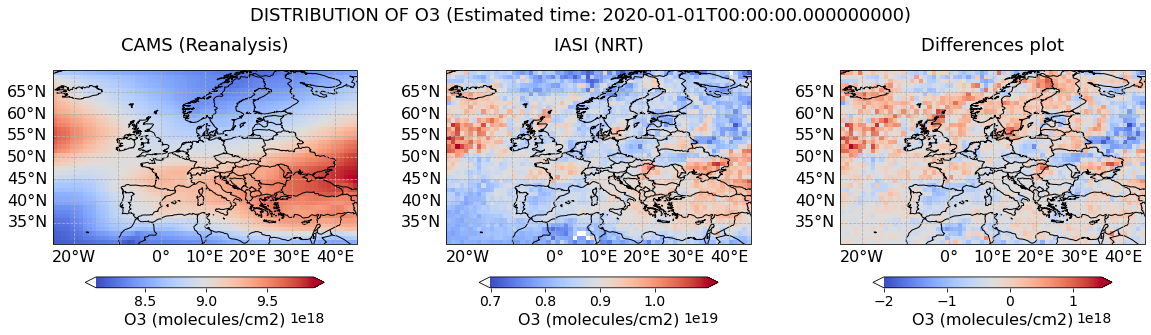

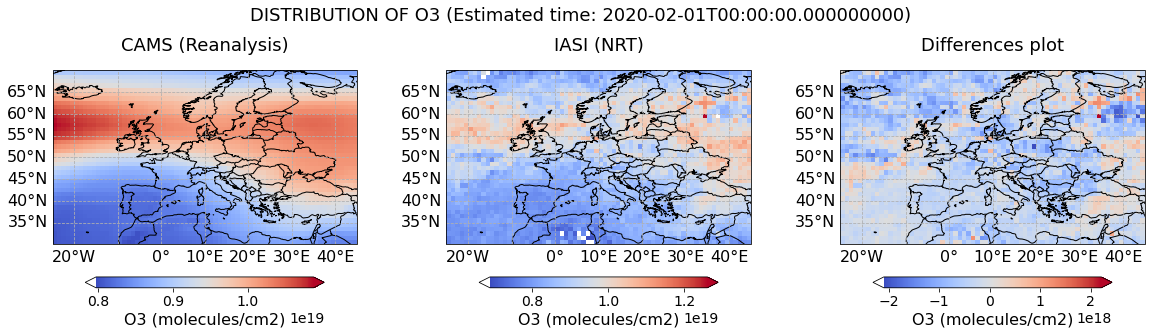

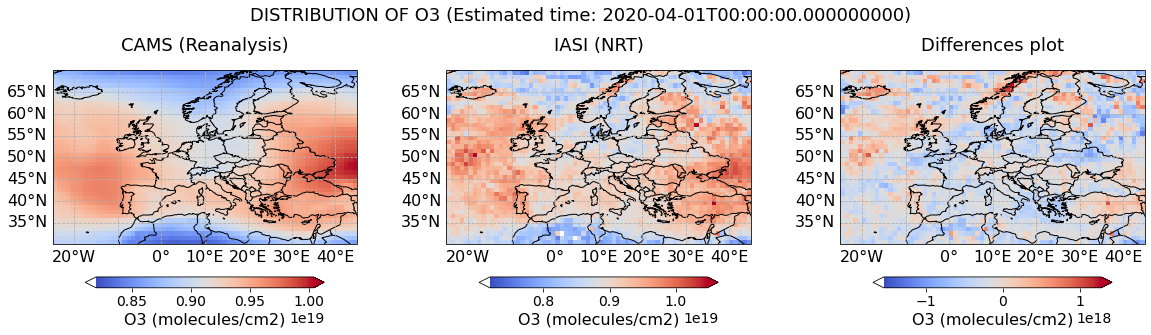

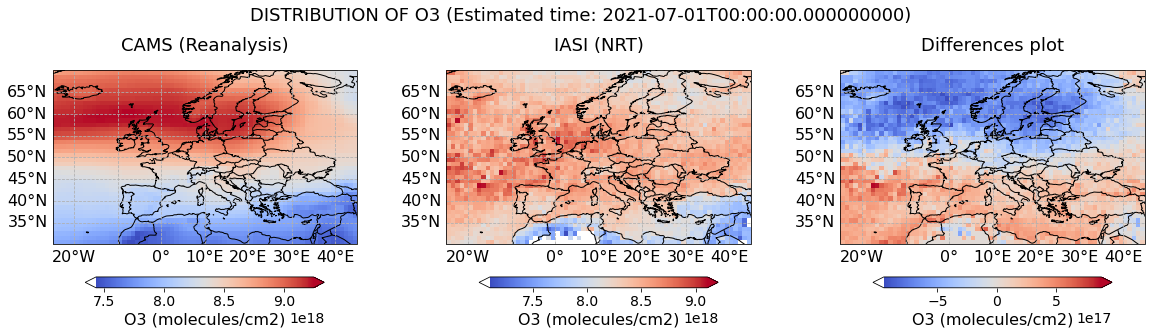

In [20]:
# Compare CAMS and IASI total columns
visualize_model_vs_sensor(model, sensor, component_nom, merged_df, plot_dates, bbox, 20, 1.10, model_type, sensor_type)

## 7. Scatter plots

Estimated time: 2020-01-01T00:00:00.000000000
Fit equation: Model O3 = Sensor O3 * 0.48 + (4.77E+18)
Coefficient of determination (R2): 0.48


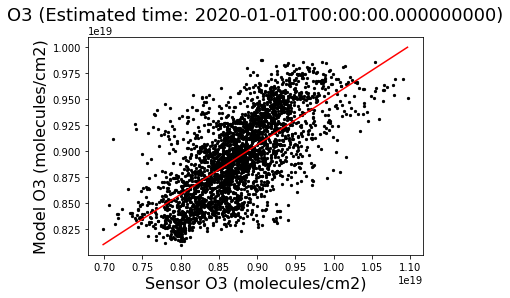

Estimated time: 2020-02-01T00:00:00.000000000
Fit equation: Model O3 = Sensor O3 * 0.81 + (2.02E+18)
Coefficient of determination (R2): 0.76


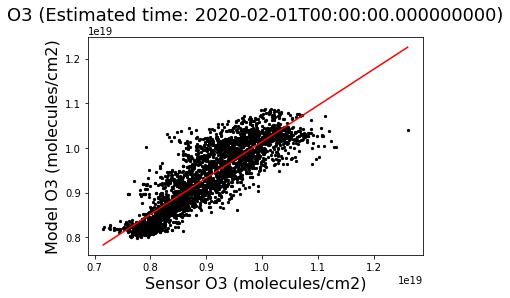

Estimated time: 2020-04-01T00:00:00.000000000
Fit equation: Model O3 = Sensor O3 * 0.59 + (3.85E+18)
Coefficient of determination (R2): 0.60


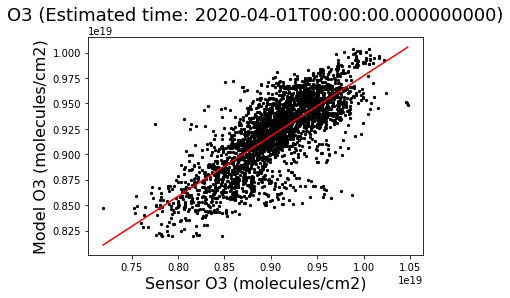

Estimated time: 2021-07-01T00:00:00.000000000
Fit equation: Model O3 = Sensor O3 * 1.06 + (-4.04E+17)
Coefficient of determination (R2): 0.35


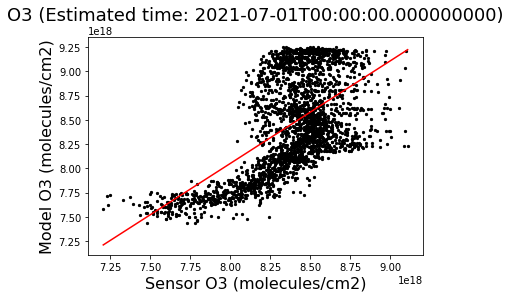

In [21]:
# Scatter plot and fit regression for CAMS vs. TROPOMI total columns
scatter_plot(merged_df.dropna(), component_nom, plot_dates, 1.05)